In [30]:
import shutil
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize 
from textblob import TextBlob
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
import re
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
from textblob import TextBlob
# [Translated]: 重新下载 Punkt 数据包
# [Translated]: nltk.download('punkt', download_dir='D:\\nltk_data')
# [Translated]: nltk.download('punkt_tab', download_dir='D:/nltk_data')
# [Translated]: nltk.download('averaged_perceptron_tagger', download_dir='D:/nltk_data')
# [Translated]: nltk.download('wordnet', download_dir='D:/nltk_data') 
# [Translated]: nltk.download('stopwords', download_dir='D:/nltk_data')

In [31]:
def remove_emoji_and_urls(text):
    """
    删除文本中的 emoji 表情和 URL 链接
    """
    if not isinstance(text, str):
        return text
    
    # [Translated]: 删除 URL 链接
    text = re.sub(r"http[s]?://\S+|www\.\S+", "", text)
    
    # [Translated]: 删除 Emoji 表情
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # 表情符号
        u"\U0001F300-\U0001F5FF"  # 符号 & 图标
        u"\U0001F680-\U0001F6FF"  # 运输 & 地图图标
        u"\U0001F700-\U0001F77F"  # Alchemical Symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r"", text)
    
    return text



def clean_csv(input):
  df = input

  for col in df.columns:
      df[col] = df[col].apply(remove_emoji_and_urls)
  return df

In [32]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [33]:
stop_words = set(stopwords.words('english'))
custom_stopwords = stop_words.union({
    'podcast', 'episode', 'show', 'episodes', '’', '“', '”', 'us', 
    'one', 'get', 'new', 'week', 'every', 'join', 'like', 'also',
    'first', 'free', 'today', 'ad', 'make', 'find', 'day', 'go',
    'use', 'daily', 'instagram', 'youtube',  'hosted',"— ","n't","ad-free", "—","com","podcasts","–","?",
     'support'
})


In [34]:
def extract_features(text):
    """从文本中提取语法特征"""
    blob = TextBlob(text)
    # [Translated]: 单词总数
    word_count = len(blob.words)
    # [Translated]: 句子总数
    sentence_count = len(blob.sentences)
    # [Translated]: 平均句子长度
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0
    # [Translated]: 词性比例
    pos_counts = blob.tags
    noun_count = len([word for word, pos in pos_counts if pos.startswith('NN')])
    verb_count = len([word for word, pos in pos_counts if pos.startswith('VB')])
    adj_count = len([word for word, pos in pos_counts if pos.startswith('JJ')])

    return pd.Series({
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_sentence_length': avg_sentence_length,
        'noun_ratio': noun_count / word_count if word_count > 0 else 0,
        'verb_ratio': verb_count / word_count if word_count > 0 else 0,
        'adj_ratio': adj_count / word_count if word_count > 0 else 0,
    })

In [35]:
def extract_sentiment(text):
    """从文本中提取情感特征"""
    blob = TextBlob(text)
    sentiment = blob.sentiment
    return pd.Series({
        'polarity': sentiment.polarity,  # 情感极性
        'subjectivity': sentiment.subjectivity  # 主观性
    })

In [36]:
# [Translated]: 定义函数：删除停用词
def remove_stopwords(text, stop_words):
    """
    从文本中移除停用词。
    
    参数：
    - text: 输入的文本字符串。
    - stop_words: 停用词集合（set）。
    
    返回：
    - 删除停用词后的文本字符串。
    """
    if isinstance(text, str):  # 确保输入是字符串
        words = text.split()  # 分词
        filtered_words = [word for word in words if word.lower() not in stop_words]  # 删除停用词
        return " ".join(filtered_words)  # 合并为句子
    return ""

In [37]:
data = pd.read_csv("D:\\.1_assignment\\628\\spotify\\cleaned_file.csv")
# [Translated]: 填充缺失值为空字符串
data['Podcast Description'] = data['Podcast Description'].fillna("")
data['Episode Description'] = data['Episode Description'].fillna("")

# [Translated]: 合并两列内容
data['Combined Description'] = data['Podcast Description'] + " " + data['Episode Description']

# [Translated]: data['Episode Description'] = data['Episode Description'].fillna("")

data['Combined Description'] = data['Combined Description'].astype(str)

In [38]:
data['Filtered Description'] = data['Combined Description'].apply(lambda x: remove_stopwords(x, custom_stopwords))
data['Filtered Description'] = data['Filtered Description'].apply(lambda x: clean_text(str(x)))
data['Filtered Description'].to_csv("D:\\.1_assignment\\628\\spotify\\stopped.csv")

In [39]:
sentiment_features = data['Combined Description'].apply(extract_sentiment)
data = pd.concat([data, sentiment_features], axis=1)

In [40]:
# [Translated]: features = data['Combined Description'].apply(extract_features)
# [Translated]: data = pd.concat([data, features], axis=1)

In [41]:
data['Tokenized Description'] = data['Filtered Description'].apply(lambda x: word_tokenize(str(x).lower()))
dictionary = Dictionary(data['Tokenized Description'])
corpus = [dictionary.doc2bow(text) for text in data['Tokenized Description']]

print(f"Dictionary Size: {len(dictionary)}")
print(f"Sample BOW: {corpus[:1]}")

Dictionary Size: 69875
Sample BOW: [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]]


In [42]:
# [Translated]: for num_topics in range(5, 20):
# [Translated]:     lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)
# [Translated]:     coherence_model = CoherenceModel(model=lda_model, texts=data['Tokenized Description'], dictionary=dictionary, coherence='c_v')
# [Translated]:     coherence_score = coherence_model.get_coherence()
# [Translated]:     print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

In [43]:
num_topics = 14

lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10, iterations=100)



In [44]:
topics = lda_model.show_topics(num_topics=-1, num_words=10, formatted=True)  
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

Topic 0: 0.025*"sports" + 0.018*"news" + 0.007*"nfl" + 0.007*"radio" + 0.006*"football" + 0.006*"times" + 0.006*"plus" + 0.006*"hurrdat" + 0.006*"picks" + 0.006*"ai"
Topic 1: 0.046*"psychology" + 0.042*"parenting" + 0.020*"podcast" + 0.017*"dr" + 0.017*"kids" + 0.015*"psychological" + 0.014*"twitter" + 0.014*"teens" + 0.012*"mental" + 0.011*"tweens"
Topic 2: 0.009*"learn" + 0.008*"visit" + 0.007*"episode" + 0.007*"choices" + 0.005*"world" + 0.005*"science" + 0.005*"the" + 0.005*"people" + 0.004*"hear" + 0.004*"history"
Topic 3: 0.017*"reading" + 0.016*"science" + 0.015*"may" + 0.010*"opinions" + 0.009*"personal" + 0.009*"liz" + 0.008*"answers" + 0.007*"psychology" + 0.007*"dwayne" + 0.007*"professional"
Topic 4: 0.014*"brain" + 0.013*"health" + 0.012*"huberman" + 0.010*"medicine" + 0.008*"lab" + 0.008*"including" + 0.008*"tools" + 0.007*"science" + 0.007*"top" + 0.007*"tool"
Topic 5: 0.015*"health" + 0.015*"life" + 0.011*"dr" + 0.008*"learn" + 0.006*"help" + 0.005*"best" + 0.005*"want"

In [45]:
def get_topic_distribution(lda_model, corpus, num_topics):
    topic_distributions = []
    for doc_bow in corpus:
        topic_dist = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
        topic_vector = [prob for _, prob in sorted(topic_dist, key=lambda x: x[0])]
        topic_distributions.append(topic_vector)
    return topic_distributions

topic_distributions = get_topic_distribution(lda_model, corpus, num_topics=14)

topic_df = pd.DataFrame(topic_distributions, columns=[f'Topic_{i}' for i in range(14)])


# [Translated]: data_with_topics = pd.concat([data.reset_index(drop=True), topic_df], axis=1)

# [Translated]: # [Translated]: 查看结果
# [Translated]: print(data_with_topics.head())

In [46]:
# [Translated]: topic_df['Max_Topic'] = topic_df.idxmax(axis=1).apply(lambda x: int(x.split('_')[1]))
# [Translated]: data_with_max_topic = pd.concat([data.reset_index(drop=True), topic_df['Max_Topic']], axis=1)

In [47]:
topic_df['Topic_Vector'] = topic_df.values.tolist()  


data['Topic_Vector'] = topic_df['Topic_Vector']

In [48]:
data.to_csv("D:\\.1_assignment\\628\\spotify\\lda_score.csv")

In [49]:
topic_df.to_csv("D:\\.1_assignment\\628\\spotify\\topic_distribution.csv")

In [50]:
all_text = " ".join(data['Combined Description'].dropna().astype(str))


blob = TextBlob(all_text)
word_counts = blob.word_counts  


filtered_word_counts = {word: count for word, count in word_counts.items() if word not in custom_stopwords}


word_freq = pd.DataFrame.from_dict(filtered_word_counts, orient='index', columns=['Frequency'])
word_freq = word_freq.sort_values(by='Frequency', ascending=False)

top_words = word_freq.head(200)  
top_words.to_csv("D:\\.1_assignment\\628\\spotify\\topwords.csv")

In [51]:
topic_vectors = np.array(data['Topic_Vector'].tolist())
topic_vectors.shape

(10000, 14)

In [52]:
other_features = data[['Duration (ms)', 'polarity', 'subjectivity']].values  
combined_features = np.hstack((topic_vectors, other_features))  

In [53]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_features)

scaled_features 

array([[-0.59283182, -0.24074093, -0.85459559, ..., -0.73362945,
         0.38843015,  0.45824811],
       [-0.59321904, -0.24185159, -0.85500029, ..., -0.18951278,
        -1.22138575,  0.63503341],
       [-0.59485331, -0.24653919, -0.85670848, ...,  0.20976173,
         0.99765873,  0.87827936],
       ...,
       [ 0.49974955, -0.25608223,  2.02520526, ..., -0.42397343,
        -0.77816465, -0.56108153],
       [-0.20672389, -0.25734738,  1.82799218, ..., -0.52371661,
         0.22286598,  0.28976763],
       [-0.24769227, -0.25801929,  1.93634495, ..., -0.35969976,
         1.09085249, -0.27793441]])

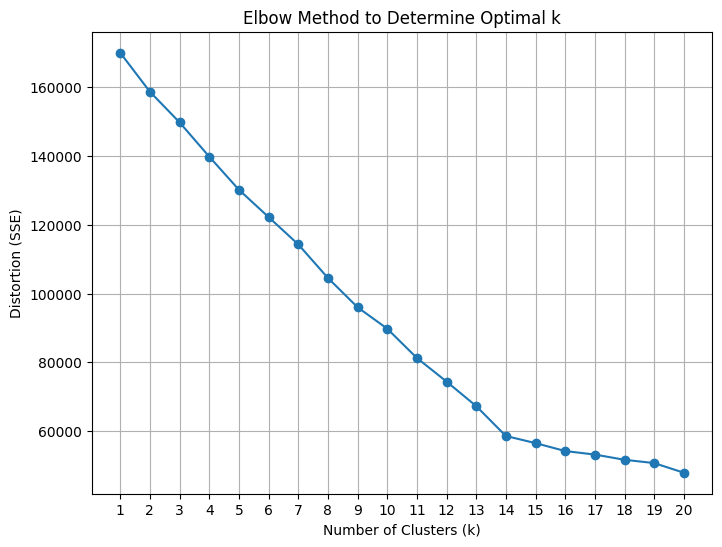

In [60]:
distortions = []
k_values = range(1, 21)  # Check k from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)  # Replace `data` with your features
    distortions.append(kmeans.inertia_)  # Inertia is the SSE

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, distortions, marker='o')
plt.xticks(k_values)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion (SSE)')
plt.title('Elbow Method to Determine Optimal k')
plt.grid(True)
plt.show()

In [62]:
n_clusters = 14
kmeans = KMeans(n_clusters=n_clusters, random_state=42)  
cluster_labels = kmeans.fit_predict(scaled_features)


data['Cluster'] = cluster_labels  

In [63]:
data.to_csv("D:\\.1_assignment\\628\\spotify\\result.csv")

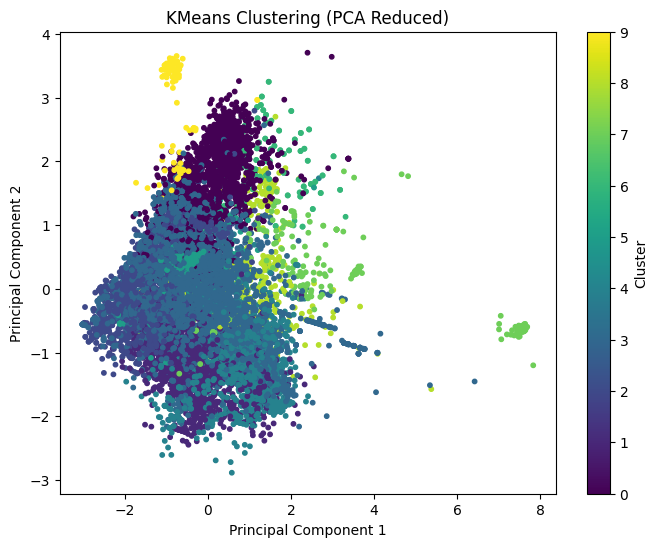

In [57]:

pca = PCA(n_components=10)
reduced_features = pca.fit_transform(scaled_features)

# [Translated]: 绘制聚类结果
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.title('KMeans Clustering (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

## test

In [58]:

def clean_text(text, stop_words):
    """
    清理文本，包括删除 Emoji、URL、标点、小写、移除停用词等。
    """
    text = remove_emoji_and_urls(text)  # 删除 emoji 和 URL
    text = re.sub(r'[^\w\s]', '', text.lower())  # 转换为小写并去掉标点
    tokens = [word for word in text.split() if word not in stop_words]  # 移除停用词
    return ' '.join(tokens)

def extract_sentiment_features(text):
    """
    从文本中提取情绪极性和主观性。
    """
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    return polarity, subjectivity

def process_new_sample(new_sample_description, other_features, stop_words, lda_model, dictionary):
    """
    处理新样本，生成完整特征向量（包括主题概率向量和情绪特征）。
    
    参数:
    - new_sample_description: 新样本的描述。
    - other_features: 新样本的其他数值特征（如时长）。
    - stop_words: 停用词集合。
    - lda_model: 已训练的 LDA 模型。
    - dictionary: LDA 模型的词典。
    
    返回:
    - combined_features: 新样本的完整特征向量。
    """
    # [Translated]: Step 1: 清理文本
    cleaned_description = clean_text(new_sample_description, stop_words)
    
    # [Translated]: Step 2: 转换描述为 LDA 主题概率向量
    bow = dictionary.doc2bow(cleaned_description.split())
    topic_vector = lda_model.get_document_topics(bow, minimum_probability=0)
    topic_vector = [prob for _, prob in sorted(topic_vector, key=lambda x: x[0])]
    
    # [Translated]: Step 3: 提取情感特征
    polarity, subjectivity = extract_sentiment_features(new_sample_description)
    
    # [Translated]: Step 4: 组合完整特征
    combined_features = np.hstack([topic_vector, other_features, [polarity, subjectivity]]).reshape(1, -1)
    return combined_features




def find_nearest_episode_from_test(
    test_row,
    stop_words,
    lda_model,
    dictionary,
    scaler,
    scaled_features,
    data,
    feature_columns,
    n_neighbors=1
):
    """
    Input a row from the test set, extract features, and find the nearest episodes while displaying test sample information.

    Parameters:
    - test_row: pd.Series, a row from the test set (including description, etc.).
    - stop_words: set, set of stop words.
    - lda_model: trained LDA model.
    - dictionary: dictionary of the LDA model.
    - scaler: fitted StandardScaler for normalization.
    - scaled_features: standardized feature array.
    - data: original DataFrame of the dataset.
    - feature_columns: list of feature column names.
    - n_neighbors: int, number of nearest neighbors to return.

    Returns:
    - nearest_episodes: DataFrame of the nearest episodes.
    - distances: Corresponding distances.
    """


    def clean_text(text, stop_words):
        """
        Clean text by removing punctuation, converting to lowercase, and removing stop words.
        """
        text = re.sub(r'[^\w\s]', '', text.lower())  # Convert to lowercase and remove punctuation
        tokens = [word for word in text.split() if word not in stop_words]  # Remove stop words
        return ' '.join(tokens)

    def extract_sentiment_features(text):
        """
        Extract polarity and subjectivity from the text.
        """
        blob = TextBlob(text)
        return blob.sentiment.polarity, blob.sentiment.subjectivity

    # [Translated]: Step 1: Extract and clean the description
    description = test_row["Episode Description"]
    cleaned_description = clean_text(description, stop_words)

    # [Translated]: Step 2: Display test sample information
    print("\n--- Test Episode Information ---")
    print(f"Podcast Name: {test_row['Podcast Name']}")
    print(f"Episode Name: {test_row['Episode Name']}")
    print(f"Original Description: {description}")
    print(f"Cleaned Description: {cleaned_description}")
    print(f"Duration: {test_row['Duration (ms)']} ms")

    # [Translated]: Step 3: Extract LDA topic vector
    bow = dictionary.doc2bow(cleaned_description.split())
    topic_vector = lda_model.get_document_topics(bow, minimum_probability=0)
    topic_vector = [prob for _, prob in sorted(topic_vector, key=lambda x: x[0])]

    # [Translated]: Step 4: Extract duration
    duration = test_row["Duration (ms)"]

    # [Translated]: Step 5: Extract sentiment features
    polarity, subjectivity = extract_sentiment_features(description)
    print(f"Sentiment Polarity: {polarity}")
    print(f"Sentiment Subjectivity: {subjectivity}")

    # [Translated]: Step 6: Combine features into a single vector
    combined_features = np.hstack([topic_vector, [duration, polarity, subjectivity]]).reshape(1, -1)

    # [Translated]: Step 7: Standardize the new sample's features
    scaled_new_sample = scaler.transform(combined_features)

    # [Translated]: Step 8: Compute Euclidean distances to all samples
    distances = euclidean_distances(scaled_new_sample, scaled_features).flatten()

    # [Translated]: Step 9: Find the nearest samples
    nearest_indices = distances.argsort()[:n_neighbors]
    nearest_episodes = data.iloc[nearest_indices].copy()
    nearest_episodes['Distance'] = distances[nearest_indices]

    return nearest_episodes, distances[nearest_indices]


In [59]:

train_data = pd.read_csv("D:\\.1_assignment\\628\\spotify\\cleaned_file.csv")
test_data = pd.read_csv("D:\\.1_assignment\\628\\spotify\\test_set.csv")

stop_words = custom_stopwords

feature_columns = [f"Topic_{i}" for i in range(14)] + ['Duration (ms)', 'Polarity', 'Subjectivity']


test_row = test_data.iloc[68]

nearest_episodes, distances = find_nearest_episode_from_test(
    test_row=test_row,
    stop_words=stop_words,
    lda_model=lda_model,               
    dictionary=dictionary,             
    scaler=scaler,                     
    scaled_features=scaled_features,   
    data=train_data,
    feature_columns=feature_columns,
    n_neighbors=5                     
)

print("Match result：")
print(nearest_episodes)


--- Test Episode Information ---
Podcast Name: The Villa of Masterpieces
Episode Name: 12. Rembrandt - Doctor Faustus (EN)
Original Description: An unsatisfied scientist seeking absolute knowledge and earthly pleasure makes a pact with the devil. This is the plot of Faust, the most famous work of Goethe, and it seems that the German philosopher was inspired to write it by a mysterious drawing from one of the greatest engravers of all time, Rembrandt. "Doctor Faustus" is a masterpiece from 1652 that conceals a story of sects, clandestine publications, and diabolical inspirations. The subject depicts a man in his study. He could easily pass for one of the many scholars-philosophers portrayed by Rembrandt: he is surrounded by books, sheets, a globe. Except the mysterious man seems to have just stopped writing to contemplate an apparition, a disk with the inscription INRI and an anagram at its center. Various hypotheses have been made about the meaning of the engraving, mainly divided bet